In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tkinter import Tk
from tkinter import filedialog as fd
import os
import math

In [2]:
#User defined constants for the program
#crystalline_layers = 0.87
#amorphous_layers = 3.24
crystalline_layers = 0
amorphous_layers = 3
totalLayers = crystalline_layers + amorphous_layers
rdf_region = "amorphous"
rdf_cutoff = 8.0 #angstroms
x_boundary = "periodic"
y_boundary = "periodic"
z_boundary = "periodic"
MD = True

#histogram parameters
nbins = 56
binbottom = 1.5
bintop = rdf_cutoff
binwidth = (bintop-binbottom)/nbins

#initialize variables that will be used
iterator = 0
nAtoms = 0
xSize = 0
ySize = 0
zSize = 0
zBoxSize = 0
z_lower_boundary = 0.0
z_upper_boundary = 0.0
atomicInformationDict = {}
atomicLocations = []
filetype='DFT'
coords_scaled = False
plotExperimentalData = True

Total atoms:  216.0
x size:  16.289992147572
y size:  16.289992147572
z size:  17.08195900923967
Sample density is:  2.2223114905642865  g/cm^3


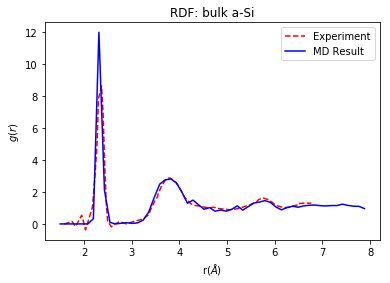

In [51]:
#Load tkinter and read in the user chosen file
root = Tk()
file = fd.askopenfilename(title = "Choose the a-Si/c-Si interface xyz file")
root.withdraw()
f = open(file, 'r')
iterator = 0

if filetype=='LAMMPS':
    for line in f:
        if iterator == 3:
            totalAtoms = float(line)
        if iterator == 5:
            newline = line.split()
            xSize = float(newline[1]) - float(newline[0])
        if iterator == 6:
            newline = line.split()
            ySize = float(newline[1]) - float(newline[0])
        if iterator == 7:
            newline = line.split()
            zSize = float(newline[1]) - float(newline[0])

            #Set z_boundaries to distinguish between layers
            if rdf_region == "amorphous":
                z_lower_bound = (crystalline_layers+0.5)*zSize/totalLayers
                z_upper_bound = (totalLayers-0.5)*zSize/totalLayers
            elif rdf_region == "interface":
                z_lower_bound = (crystalline_layers-0.5)*zSize/totalLayers
                z_upper_bound = (crystalline_layers + 0.5)*zSize/totalLayers
            elif rdf_region == "crystalline":
                z_lower_bound = 0.0
                z_upper_bound = (crystalline_layers - 0.5)*zSize/totalLayers

        elif iterator >= 9:
            if MD:
                newline = line.split()
                floatline = [float(i) for i in newline]
                atomicInformationDict[floatline[0]] = [floatline[1], floatline[2:]]
                if coords_scaled:
                    if z_lower_bound <= floatline[4]*zSize and floatline[4]*zSize<=z_upper_bound:
                        unscaledCoordinates = [floatline[2]*xSize, floatline[3]*ySize, floatline[4]*zSize]
                        atomicLocations.append(unscaledCoordinates)
                        nAtoms += 1
                else:
                    if z_lower_bound <= floatline[4] and floatline[4] <= z_upper_bound:
                        atomicLocations.append(floatline[2:])
                        nAtoms += 1
            else:
                newline = line.split()
                #print(newline)
                floatline = [float(i) for i in newline[1:]]
                if z_lower_bound <= floatline[2] and floatline[2]<=z_upper_bound:
                    coordinates = [floatline[0], floatline[1], floatline[2]]
                    atomicLocations.append(coordinates)
                    nAtoms += 1
        iterator += 1
else:
    for line in f:
        if iterator == 2:
            totalAtoms = float(line.split()[0])
        if iterator == 6:
            newline = line.split()
            xSize = float(newline[1]) - float(newline[0])
        if iterator == 7:
            newline = line.split()
            ySize = float(newline[1]) - float(newline[0])
        if iterator == 8:
            newline = line.split()
            zSize = float(newline[1]) - float(newline[0])

            #Set z_boundaries to distinguish between layers
            if rdf_region == "amorphous":
                z_lower_bound = (crystalline_layers+0.5)*zSize/totalLayers
                z_upper_bound = (totalLayers-0.5)*zSize/totalLayers
            elif rdf_region == "interface":
                z_lower_bound = (crystalline_layers-0.5)*zSize/totalLayers
                z_upper_bound = (crystalline_layers + 0.5)*zSize/totalLayers
            elif rdf_region == "crystalline":
                z_lower_bound = 0.0
                z_upper_bound = (crystalline_layers - 0.5)*zSize/totalLayers

        elif iterator >= 16:
            if MD:
                newline = line.split()
                floatline = [float(i) for i in newline]
                atomicInformationDict[floatline[0]] = [floatline[1], floatline[2:]]
                if coords_scaled:
                    if z_lower_bound <= floatline[4]*zSize and floatline[4]*zSize<=z_upper_bound:
                        unscaledCoordinates = [floatline[2]*xSize, floatline[3]*ySize, floatline[4]*zSize]
                        atomicLocations.append(unscaledCoordinates)
                        nAtoms += 1
                else:
                    if z_lower_bound <= floatline[4] and floatline[4] <= z_upper_bound:
                        atomicLocations.append(floatline[2:])
                        nAtoms += 1
            else:
                newline = line.split()
                #print(newline)
                floatline = [float(i) for i in newline[1:]]
                if z_lower_bound <= floatline[2] and floatline[2]<=z_upper_bound:
                    coordinates = [floatline[0], floatline[1], floatline[2]]
                    atomicLocations.append(coordinates)
                    nAtoms += 1
        iterator += 1

volume = xSize*ySize*zSize
print("Total atoms: ", totalAtoms)
print("x size: ", xSize)
print("y size: ", ySize)
print("z size: ", zSize)
density = totalAtoms*(4.6637*10**-23)/(volume*10**-24) #g/cm^3
print("Sample density is: ",density," g/cm^3")
#make an array of all the atoms
atomicArray = np.array(atomicLocations)

#set the box size in the z direction
if z_boundary == "periodic":
    zBoxSize = zSize
else:
    zBoxSize = z_upper_bound - z_lower_bound

#prepare the histogram corrections due to ideal gas
numberDensity = nAtoms/(xSize*ySize*zBoxSize)
binBottomEdges = np.arange(binbottom, bintop, binwidth)
idealGasRDF = numberDensity*4*math.pi*np.square(binBottomEdges)*binwidth

#calculate the distance between every atomic pair, if all non-periodic boundary conditions
#for i in range(atomicArray.shape[0] - 1):
#    distances.extend(np.linalg.norm(atomicArray[i+1:,:] - atomicArray[i,:], axis=1))
totalCount = np.zeros(nbins)
for n, i in enumerate(atomicArray[:-1]):
    ndistances = []
    for j in np.concatenate((atomicArray[:n], atomicArray[n+1:]), axis=0):
        #print(i)
        #print(j)
        if x_boundary == "periodic":
            xDistance = min(abs(i[0]-j[0]),abs(min(i[0],j[0]) - max(i[0], j[0]) + xSize))
        else:
            xDistance = abs(i[0] - j[0])
            
        if y_boundary == "periodic":
            yDistance = min(abs(i[1]-j[1]),abs(min(i[1],j[1]) - max(i[1], j[1]) + ySize))
        else:
            yDistance = abs(i[1] - j[1])
            
        if z_boundary == "periodic":
            zDistance = min(abs(i[2]-j[2]),abs(min(i[2],j[2]) - max(i[2], j[2]) + zSize))
        else:
            zDistance = abs(i[2] - j[2])
        
        distance = math.sqrt(xDistance**2 + yDistance**2 + zDistance**2)
        if distance < rdf_cutoff:
            ndistances.append(distance)
      
    ndistancearray = np.asarray(ndistances)
    count, bins = np.histogram(ndistancearray, nbins, (binbottom, bintop))
    
    if z_boundary != "periodic":
        #correction due to the fact that the rdf sphere extends beyond the simulation box
        zElevation = min(i[2] - z_lower_bound, z_upper_bound - i[2])
        sphericalCaps = np.maximum(np.zeros(binBottomEdges.size), binBottomEdges-zElevation)
        idealGasRDF = numberDensity*binwidth*(4*math.pi*np.square(binBottomEdges) - 2*math.pi*binBottomEdges*sphericalCaps)
    else:
        #no correction needed, due to periodic boundary conditions
        idealGasRDF = numberDensity*binwidth*(4*math.pi*np.square(binBottomEdges))
    
    count = np.divide(count, nAtoms*idealGasRDF)
    totalCount += count
    
if plotExperimentalData:
    root = Tk()
    file = fd.askopenfilename(title = "Choose the experimental rdf file")
    root.withdraw()
    f = open(file, 'r')
    x_data = []
    y_data = []
    for line in f:
        x_data.append(float(line.split(',')[0]))
        y_data.append(float(line.split(',')[1]))
    x_array = np.asarray(x_data)
    y_array = np.asarray(y_data)
    width = .039 #angstroms
    y_array =np.divide(y_array, 4*math.pi*np.square(x_array)*width)
    plt.plot(x_array, y_array, 'r--',label='Experiment')

#plot the rdf
plt.plot(binBottomEdges, totalCount, 'b-',label='MD Result')
plt.ylabel("$g(r)$")
plt.xlabel("r($\AA$)")
plt.legend()
plt.savefig('RDF.png', format = 'png', dpi = 300)
plt.show()

Sample density is:  2.261447988453819  g/cm^3
Sample density is:  2.285620648681298  g/cm^3
Sample density is:  2.2337367178840077  g/cm^3
Sample density is:  2.266631002000191  g/cm^3
Sample density is:  2.234475165036955  g/cm^3
Sample density is:  2.237247641555969  g/cm^3
Sample density is:  2.2486088750923674  g/cm^3
Sample density is:  2.2953534240191913  g/cm^3
Sample density is:  2.2843083816636995  g/cm^3
Sample density is:  2.2705228833553064  g/cm^3
Sample density is:  2.282094974656552  g/cm^3
Sample density is:  2.255965568793289  g/cm^3
Sample density is:  2.250521004303305  g/cm^3
Sample density is:  2.2754846547516943  g/cm^3
Sample density is:  2.2478142260070593  g/cm^3
Sample density is:  2.226774086949099  g/cm^3
Sample density is:  2.265677235804344  g/cm^3
Sample density is:  2.2692192159479796  g/cm^3
Sample density is:  2.250058521639874  g/cm^3
Sample density is:  2.2795443781155043  g/cm^3
Sample density is:  2.2865404335816755  g/cm^3
Sample density is:  2.27

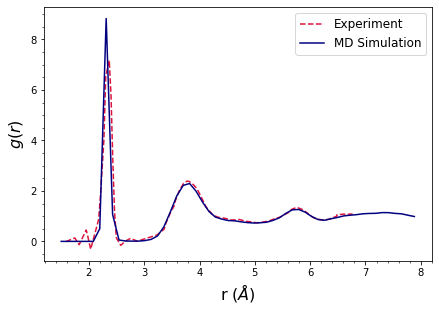

In [13]:
#Load tkinter and read in the user chosen file
root = Tk()
folder = fd.askdirectory(title = "Choose the folder containing the a-Si files")
root.withdraw()
totalAtoms = 216
totalCount = np.zeros(nbins)
files = os.listdir(folder)
nStructures = 0
totalDensity = 0
for file in files:
    filename = folder + "/" + file
    f = open(filename,'r')
    
    nAtoms = 0
    iterator = 0
    atomicInformationDict = {}
    atomicLocations = []
    nStructures += 1
    for line in f:
        if iterator == 3:
            newline = line.split()
            xSize = float(newline[1]) - float(newline[0])
        if iterator == 4:
            newline = line.split()
            ySize = float(newline[1]) - float(newline[0])
        if iterator == 5:
            newline = line.split()
            zSize = float(newline[1]) - float(newline[0])

        elif iterator >= 7:
            newline = line.split()
            floatline = [float(i) for n, i in enumerate(newline) if n>0]
            identifier = iterator - 6
            atomicInformationDict[identifier] = floatline
            atomicLocations.append(floatline)
            nAtoms += 1
            
        iterator += 1

    volume = xSize*ySize*zSize
    density = totalAtoms*(4.6637*10**-23)/(volume*10**-24) #g/cm^3
    totalDensity += density
    print("Sample density is: ",density," g/cm^3")
    #make an array of all the atoms
    atomicArray = np.array(atomicLocations)

    #set the box size in the z direction
    if z_boundary == "periodic":
        zBoxSize = zSize
    else:
        zBoxSize = z_upper_bound - z_lower_bound

    #prepare the histogram corrections due to ideal gas
    numberDensity = totalAtoms/(xSize*ySize*zBoxSize)
    binBottomEdges = np.arange(binbottom, bintop, binwidth)
    idealGasRDF = numberDensity*4*math.pi*np.square(binBottomEdges)*binwidth

    #calculate the distance between every atomic pair, if all non-periodic boundary conditions
    #for i in range(atomicArray.shape[0] - 1):
    #    distances.extend(np.linalg.norm(atomicArray[i+1:,:] - atomicArray[i,:], axis=1))
    for n, i in enumerate(atomicArray[:-1]):
        ndistances = []
        for j in np.concatenate((atomicArray[:n], atomicArray[n+1:]), axis=0):
            #print(i)
            #print(j)
            if x_boundary == "periodic":
                xDistance = min(abs(i[0]-j[0]),abs(min(i[0],j[0]) - max(i[0], j[0]) + xSize))
            else:
                xDistance = abs(i[0] - j[0])

            if y_boundary == "periodic":
                yDistance = min(abs(i[1]-j[1]),abs(min(i[1],j[1]) - max(i[1], j[1]) + ySize))
            else:
                yDistance = abs(i[1] - j[1])

            if z_boundary == "periodic":
                zDistance = min(abs(i[2]-j[2]),abs(min(i[2],j[2]) - max(i[2], j[2]) + zSize))
            else:
                zDistance = abs(i[2] - j[2])

            distance = math.sqrt(xDistance**2 + yDistance**2 + zDistance**2)
            if distance < rdf_cutoff:
                ndistances.append(distance)

        ndistancearray = np.asarray(ndistances)
        count, bins = np.histogram(ndistancearray, nbins, (binbottom, bintop))

        if z_boundary != "periodic":
            #correction due to the fact that the rdf sphere extends beyond the simulation box
            zElevation = min(i[2] - z_lower_bound, z_upper_bound - i[2])
            sphericalCaps = np.maximum(np.zeros(binBottomEdges.size), binBottomEdges-zElevation)
            idealGasRDF = numberDensity*binwidth*(4*math.pi*np.square(binBottomEdges) - 2*math.pi*binBottomEdges*sphericalCaps)
        else:
            #no correction needed, due to periodic boundary conditions
            idealGasRDF = numberDensity*binwidth*(4*math.pi*np.square(binBottomEdges))

        #totalCount += count
        count = np.divide(count, nAtoms*idealGasRDF)
        totalCount += count
        
averageCount = np.divide(totalCount, nStructures)
averageDensity = totalDensity/nStructures

print("The average sample density is: ",averageDensity," g/cm^3")
    
fig,ax = plt.subplots(figsize=(6.5,4.3))
plt.subplots_adjust(left=0.15, bottom = 0.15, right = 0.98, top = 0.97, wspace = 0, hspace = 0)
if plotExperimentalData:
    root = Tk()
    file = fd.askopenfilename(title = "Choose the experimental rdf file")
    root.withdraw()
    f = open(file, 'r')
    x_data = []
    y_data = []
    for line in f:
        x_data.append(float(line.split(',')[0]))
        y_data.append(float(line.split(',')[1]))
    x_array = np.asarray(x_data)
    y_array = np.asarray(y_data)
    width = .047 #angstroms, was 0.39
    y_array =np.divide(y_array, 4*math.pi*np.square(x_array)*width)
    plt.plot(x_array, y_array, 'r--',label='Experiment',color='crimson')

#plot the rdf
plt.plot(binBottomEdges, averageCount, 'b-',label='MD Simulation', color='navy')
plt.ylabel("$g(r)$",fontsize=16)
plt.xlabel("r ($\AA$)",fontsize=16)
ax.minorticks_on()
plt.legend(fontsize=12)
plt.savefig('RDF.png', format = 'png', dpi = 300)
plt.show()